In [ ]:
import os

os.environ["OPENAI_API_KEY"]=""
os.environ["GOOGLE_API_KEY"] = ""
os.environ["GROQ_API_KEY"] = ""
os.environ["TOGETHER_API_KEY"] = ""

In [2]:
import sugardata as su
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset, Dataset, DatasetDict, concatenate_datasets
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from transformers import pipeline, AutoModelForSequenceClassification, AutoTokenizer, DataCollatorWithPadding, TrainingArguments, Trainer, EarlyStoppingCallback

In [3]:
sample_data = su.generate_sentiment_data(
    concept="Programming Languages",
    language="en",
    batch_size=16,
    label_options=["Positive", "Negative", "Neutral"],
    n_sentence=100,
    export_type="dataframe",
    vendor="ollama",
    model="gemma3:12b"
)

In [4]:
sample_data

,index,concept,aspect,writing_style,medium,persona,intention,sentence_length,generated_text,dimension,sentiment
0,0,Programming Languages,Low-level languages are often used in embedded...,humorous,short story,parent,angry,Short Paragraph,"Honestly, these low-level languages! It’s like...","Abstraction Level (High-Level, Low-Level, Asse...",Negative
1,1,Programming Languages,Bytecode Compilation: Languages like Java and ...,metafictional,script,playwright,cynical,Unfinished sentence,"The script demands efficiency, doesn’t it? And...","Execution Model (Compiled, Interpreted, Hybrid)",Neutral
2,2,Programming Languages,Emergence of assembly language and symbolic re...,allegorical,instruction manual,first-person narrator,enthusiastic,1 short sentence,"Ah, the genesis of assembly language! Like dil...","Historical Context (First Generation, Second G...",Positive
3,3,Programming Languages,Low-level languages are often used in embedded...,didactic,poem,playwright,melancholic,Short Paragraph,"Ah, the whisper of low-level languages – a nec...","Abstraction Level (High-Level, Low-Level, Asse...",Positive
4,4,Programming Languages,Imperative languages often involve explicit me...,analytical,poem,scientist,inform,A couple of words,Imperative languages: a sculptor's hand. Preci...,"Paradigm (Imperative, Declarative, Functional,...",Positive
...,...,...,...,...,...,...,...,...,...,...,...
95,95,Programming Languages,C++ and C# are widely used for game developmen...,satirical,poem,advertiser,express opinion,Short Paragraph,"Oh, game development! A pixelated paradise, th...","Primary Use Case (Web Development, Mobile Deve...",Negative
96,96,Programming Languages,Declarative languages express *what* computati...,descriptive,play,unreliable narrator,complain,1 sentence,(Lights flicker on a stage littered with tangl...,"Paradigm (Imperative, Declarative, Functional,...",Negative
97,97,Programming Languages,Interpreter Overhead: Interpreted languages in...,critical,report,blogger,joyful,1 short sentence,"The interpreter's relentless, line-by-line ass...","Execution Model (Compiled, Interpreted, Hybrid)",Negative
98,98,Programming Languages,Examples of high-level languages include Pytho...,expository,podcast transcript,elder,melancholic,Long Paragraph,"Ah, yes, the ascent to higher abstraction leve...","Abstraction Level (High-Level, Low-Level, Asse...",Positive


In [5]:
vendors = {
    "openai": "gpt-4o-mini",
    "gemini": "gemini-1.5-flash",
    "groq": "meta-llama/llama-4-scout-17b-16e-instruct",
    "ollama": "gemma3:12b",
    #"together": "mistralai/Mistral-7B-Instruct-v0.2"
}

new_data_dict = await su.generate_sentiment_multi_vendor_async(
    concept="Programming Languages",
    vendors=vendors,
    language="en",
    batch_size=16,
    label_options=["Positive", "Negative", "Neutral"],
    n_sentence=3000,
    export_type="hg",
    verbose=True,
)

Processing batch 1/188
Retrying abatch (attempt 1) due to: OutputParserException('Invalid json output: Here is the generated text:\n\n```\n{\n  "index": 78,\n  "generated_text": "As I sat in my office, surrounded by screens that seemed to whisper sweet nothings of code and creation, I pondered the realm of Declarative Programming Languages - a landscape where Prolog and SQL reign supreme, their declarative nature a double-edged sword, cutting both ways, freeing us from the shackles of procedure, yet confining us to the prison of logic, and I began to wonder, are we truly masters of our domain, or merely puppets dancing on the strings of...",\n}\n```\nFor troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/OUTPUT_PARSING_FAILURE ')
Processing batch 1/188
Processing batch 1/188
Processing batch 1/188
Retrying abatch (attempt 1) due to: OutputParserException('Invalid json output: Here is a creative snippet that expresses a negative sentiment toward the aspect 

In [6]:
print(new_data_dict["openai"])

Dataset({
    features: ['index', 'concept', 'aspect', 'writing_style', 'medium', 'persona', 'intention', 'sentence_length', 'generated_text', 'dimension', 'sentiment'],
    num_rows: 3000
})


In [7]:
dataset = concatenate_datasets(list(new_data_dict.values()))
print(dataset)

Dataset({
    features: ['index', 'concept', 'aspect', 'writing_style', 'medium', 'persona', 'intention', 'sentence_length', 'generated_text', 'dimension', 'sentiment'],
    num_rows: 12000
})


In [8]:
print(dataset[0])

{'index': 0, 'concept': 'Programming Languages', 'aspect': 'JavaScript', 'writing_style': 'metafictional', 'medium': 'article', 'persona': 'historical figure', 'intention': 'warn', 'sentence_length': 'Short Paragraph', 'generated_text': "Picture me, a humble architect of algorithms, peering through the annals of time to witness a wondrous creation: JavaScript. This linguistic marvel dances like a nimble sprite on the web's expansive canvas, weaving spells of interactivity and vibrancy. In the realm of programming languages, it reigns supreme, its flexibility flowing like a meandering river, shaping the landscape of digital innovation. Beware, though, for its bounty is vast, inviting both the daring and the timid to embrace its brilliance. Let us cherish this gem, a beacon of possibility amidst the shadows of complexity!", 'dimension': 'Popular Programming Languages', 'sentiment': 'Positive'}


In [9]:
dataset = dataset.class_encode_column("sentiment")
# 1. Shuffle the full Dataset
shuffled = dataset.shuffle(seed=42)

# 2. Split off 30% for test+validation (so train = 70%)
split_1 = shuffled.train_test_split(test_size=0.30, seed=42, stratify_by_column="sentiment")
train_ds = split_1["train"]
test_valid_ds = split_1["test"]

# 3. Split that 30% evenly into test (15%) and validation (15%)
split_2 = test_valid_ds.train_test_split(test_size=0.50, seed=42, stratify_by_column="sentiment")
valid_ds = split_2["train"]   # 0.5 * 0.30 = 0.15 of original
test_ds  = split_2["test"]    # 0.5 * 0.30 = 0.15 of original

# 4. Build the DatasetDict
ds = DatasetDict({
    "train": train_ds,
    "validation": valid_ds,
    "test": test_ds
})

print(ds)


Casting to class labels:   0%|          | 0/12000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['index', 'concept', 'aspect', 'writing_style', 'medium', 'persona', 'intention', 'sentence_length', 'generated_text', 'dimension', 'sentiment'],
        num_rows: 8400
    })
    validation: Dataset({
        features: ['index', 'concept', 'aspect', 'writing_style', 'medium', 'persona', 'intention', 'sentence_length', 'generated_text', 'dimension', 'sentiment'],
        num_rows: 1800
    })
    test: Dataset({
        features: ['index', 'concept', 'aspect', 'writing_style', 'medium', 'persona', 'intention', 'sentence_length', 'generated_text', 'dimension', 'sentiment'],
        num_rows: 1800
    })
})


In [10]:
# 1. Choose a folder
out_dir = "./my_saved_dataset"

# 2. Save to disk
ds.save_to_disk(out_dir)

Saving the dataset (0/1 shards):   0%|          | 0/8400 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1800 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1800 [00:00<?, ? examples/s]

In [11]:
print(ds["train"][0])

{'index': 1941, 'concept': 'Programming Languages', 'aspect': 'Class', 'writing_style': 'ironic', 'medium': 'blog post', 'persona': 'blogger', 'intention': 'express opinion', 'sentence_length': '1 short phrase', 'generated_text': "The 'class' in object-oriented programming languages - a rigid cage that confines creativity, a flawed facade masquerading as flexibility.", 'dimension': 'Object-Oriented Programming Languages', 'sentiment': 0}


In [12]:
# 1. Get the ClassLabel object
label_feature = dataset.features["sentiment"]

# 2. See a summary
print(label_feature)
# → ClassLabel(num_classes=3, names=['negative','neutral','positive'], id=None)

# 3. List out the names in order of their integer IDs
print(label_feature.names)
# → ['negative', 'neutral', 'positive']

# 4. Build an explicit dict of ID → original label
mapping = { i: name for i, name in enumerate(label_feature.names) }
print(mapping)

ClassLabel(names=['Negative', 'Neutral', 'Positive'])
['Negative', 'Neutral', 'Positive']
{0: 'Negative', 1: 'Neutral', 2: 'Positive'}


Counts DataFrame:
    train  validation  test
0   2807         602   601
1   2836         607   608
2   2757         591   591


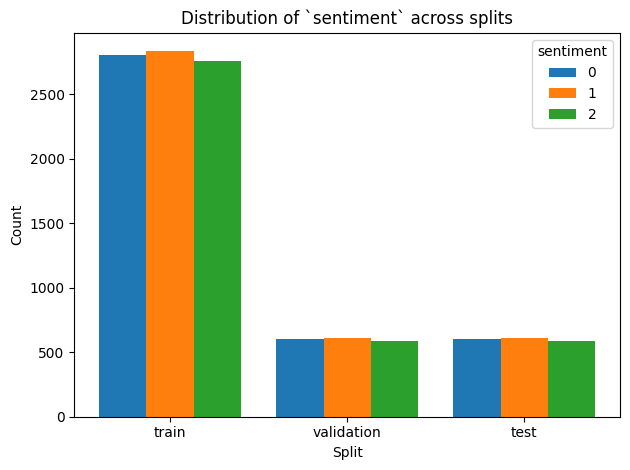

In [13]:
def plot_feature_distribution(ds, feature_name: str):
    # 1) Collect value‐counts for each split
    counts = {}
    all_categories = set()
    for split_name, split in ds.items():
        df = split.to_pandas()
        vc = df[feature_name].value_counts()
        counts[split_name] = vc
        all_categories.update(vc.index.tolist())
    
    # 2) Build a DataFrame: rows=categories, cols=splits
    categories = sorted(all_categories)
    df_counts = pd.DataFrame(
        { split: counts[split].reindex(categories, fill_value=0)
          for split in counts },
        index=categories
    )

    print("Counts DataFrame:\n", df_counts)
    
    # 3) Transpose for plotting: rows=splits, cols=categories
    df_plot = df_counts.T
    
    # 4) Plot grouped bar chart with splits on x-axis
    x = np.arange(len(df_plot.index))
    n_categories = len(df_plot.columns)
    width = 0.8 / n_categories
    
    _, ax = plt.subplots()
    for i, category in enumerate(df_plot.columns):
        ax.bar(x + i * width, df_plot[category], width, label=category)
    
    ax.set_xticks(x + width * (n_categories - 1) / 2)
    ax.set_xticklabels(df_plot.index, rotation=0)
    ax.set_xlabel("Split")
    ax.set_ylabel("Count")
    ax.set_title(f"Distribution of `{feature_name}` across splits")
    ax.legend(title=feature_name)
    plt.tight_layout()
    plt.show()

plot_feature_distribution(ds, "sentiment")

In [14]:
BASE_MODEL = "cardiffnlp/twitter-roberta-base-sentiment"

In [15]:
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL)
model = AutoModelForSequenceClassification.from_pretrained(BASE_MODEL)

# Access label mappings
LABEL2ID = model.config.label2id
ID2LABEL = model.config.id2label

print("label2id:", LABEL2ID)
print("id2label:", ID2LABEL)

label2id: {'LABEL_0': 0, 'LABEL_1': 1, 'LABEL_2': 2}
id2label: {0: 'LABEL_0', 1: 'LABEL_1', 2: 'LABEL_2'}


In [16]:
base_pipe = pipeline("text-classification", model=BASE_MODEL, device=0)

pred_good = base_pipe("Good")
pred_bad = base_pipe("Bad")
pred_neutral = base_pipe("Neutral")

print(f"Positive prediction: {pred_good}")
print(f"Negative prediction: {pred_bad}")
print(f"Neutral prediction: {pred_neutral}")

Device set to use cuda:0


Positive prediction: [{'label': 'LABEL_2', 'score': 0.6097785830497742}]
Negative prediction: [{'label': 'LABEL_0', 'score': 0.495851069688797}]
Neutral prediction: [{'label': 'LABEL_1', 'score': 0.7306323647499084}]


In [17]:
MODEL_LABEL_MAPPING = {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    0: "LABEL_0",
    1: "LABEL_1",
    2: "LABEL_2",
}


DATASET_LABELS = [
    ID2LABEL.get(0),
    ID2LABEL.get(1),
    ID2LABEL.get(2),
]

In [18]:
print(ds["train"][1])

def encode_labels(example):
    model_text_label =MODEL_LABEL_MAPPING.get(example['sentiment'])
    example['sentiment'] = LABEL2ID[model_text_label]
    return example

ds = ds.map(encode_labels)

print(ds["train"][1])

{'index': 1650, 'concept': 'Programming Languages', 'aspect': 'Generational Garbage Collection', 'writing_style': 'satirical', 'medium': 'podcast transcript', 'persona': 'marketer', 'intention': 'summarize', 'sentence_length': 'Long Paragraph', 'generated_text': "So, generational garbage collection, huh? Sounds efficient, right?  Wrong!  It's like a meticulously organized dumpster fire – sure, the trash *eventually* gets dealt with, but the process is agonizingly slow, a creeping, crawling blight on performance. Imagine watching paint dry, only instead of paint, it's your program's memory slowly, painstakingly being reclaimed.  It’s a bureaucratic nightmare disguised as a memory management system.  Frankly, this 'generational' approach feels more like generational trauma for your application – a legacy of slowdowns passed down from one memory allocation to the next.  This is not the sleek, streamlined experience we promised; it’s the digital equivalent of waiting in line at the DMV for

Map:   0%|          | 0/8400 [00:00<?, ? examples/s]

Map:   0%|          | 0/1800 [00:00<?, ? examples/s]

Map:   0%|          | 0/1800 [00:00<?, ? examples/s]

{'index': 1650, 'concept': 'Programming Languages', 'aspect': 'Generational Garbage Collection', 'writing_style': 'satirical', 'medium': 'podcast transcript', 'persona': 'marketer', 'intention': 'summarize', 'sentence_length': 'Long Paragraph', 'generated_text': "So, generational garbage collection, huh? Sounds efficient, right?  Wrong!  It's like a meticulously organized dumpster fire – sure, the trash *eventually* gets dealt with, but the process is agonizingly slow, a creeping, crawling blight on performance. Imagine watching paint dry, only instead of paint, it's your program's memory slowly, painstakingly being reclaimed.  It’s a bureaucratic nightmare disguised as a memory management system.  Frankly, this 'generational' approach feels more like generational trauma for your application – a legacy of slowdowns passed down from one memory allocation to the next.  This is not the sleek, streamlined experience we promised; it’s the digital equivalent of waiting in line at the DMV for

In [19]:
def evaluate_sentiment_model(
        pi: pipeline,
        data: Dataset,
        text_field: str,
        true_label_field: str,
        verbose: bool = True,
    ):
    y_true = []
    y_pred = []

    for idx, row in enumerate(data):
        text = row[text_field]
        if isinstance(text, str) and len(text) > 0:
            text = text.strip()
            text = text[:2000]

        pred = pi(text)[0]["label"]
        true = ID2LABEL[row[true_label_field]]
        y_true.append(true)
        y_pred.append(pred)

        if verbose and idx % 1000 == 0:
            print(f"Processed {idx} rows: {pred} vs {true}")
    
    acc = accuracy_score(y_true, y_pred)
    f1_macro = f1_score(y_true, y_pred, average='macro')
    f1_weighted = f1_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    cm = confusion_matrix(y_true, y_pred,labels=DATASET_LABELS)

    # Per-class F1 (optional, for analysis)
    f1_per_class = f1_score(y_true, y_pred, average=None)

    return {
        "accuracy": acc,
        "f1_macro": f1_macro,
        "f1_weighted": f1_weighted,
        "precision": precision,
        "recall": recall,
        "confusion_matrix": cm,
        "f1_per_class_0": f1_per_class[0],
        "f1_per_class_1": f1_per_class[1],
        "f1_per_class_2": f1_per_class[2],
        
    }

base_test_evals = evaluate_sentiment_model(base_pipe, ds["test"], "generated_text", "sentiment")
print(base_test_evals)

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Processed 0 rows: LABEL_1 vs LABEL_1
Processed 1000 rows: LABEL_1 vs LABEL_0
{'accuracy': 0.705, 'f1_macro': 0.6965619852061787, 'f1_weighted': 0.6956403842608466, 'precision': 0.6998193864146677, 'recall': 0.705, 'confusion_matrix': array([[489,  99,  13],
       [100, 284, 224],
       [ 24,  71, 496]]), 'f1_per_class_0': np.float64(0.8056013179571664), 'f1_per_class_1': np.float64(0.5348399246704332), 'f1_per_class_2': np.float64(0.7492447129909365)}


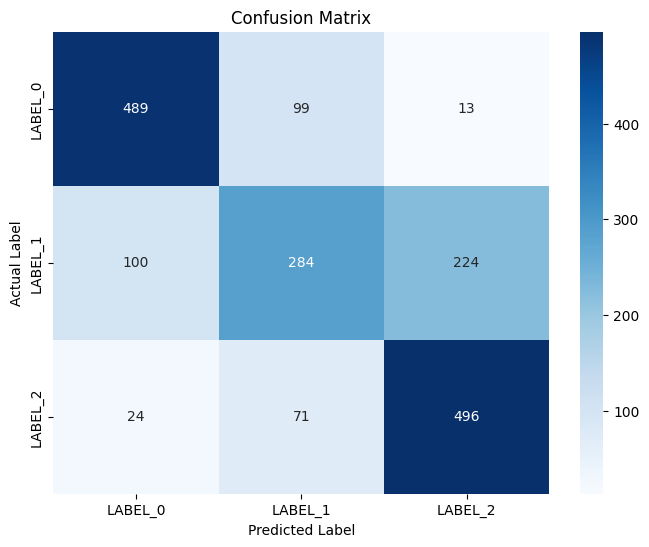

In [20]:
def plot_cm(cm):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=DATASET_LABELS, yticklabels=DATASET_LABELS)

    plt.xlabel('Predicted Label')
    plt.ylabel('Actual Label')
    plt.title('Confusion Matrix')
    plt.show()


plot_cm(base_test_evals["confusion_matrix"])

In [21]:
output_dir = "ft_sentiment_model"

In [22]:
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL)
model = AutoModelForSequenceClassification.from_pretrained(BASE_MODEL)

In [23]:
def tokenize_function(examples):
    return tokenizer(examples['generated_text'],
                     padding='max_length',
                     truncation=True,
                     max_length=512)

train_dataset = ds['train']
test_dataset = ds['test']
validation_dataset = ds['validation']

tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_test = test_dataset.map(tokenize_function, batched=True)
tokenized_validation = validation_dataset.map(tokenize_function, batched=True)

tokenized_train = tokenized_train.rename_column("sentiment", "label")
tokenized_test = tokenized_test.rename_column("sentiment", "label")
tokenized_validation = tokenized_validation.rename_column("sentiment", "label")

tokenized_train = tokenized_train.remove_columns(['index', 'concept', 'aspect', 'writing_style', 'medium', 'persona', 'intention', 'sentence_length', 'generated_text', 'dimension'])
tokenized_test = tokenized_test.remove_columns(['index', 'concept', 'aspect', 'writing_style', 'medium', 'persona', 'intention', 'sentence_length', 'dimension'])
tokenized_validation = tokenized_validation.remove_columns(['index', 'concept', 'aspect', 'writing_style', 'medium', 'persona', 'intention', 'sentence_length', 'dimension'])

tokenized_train.set_format('torch')
tokenized_test.set_format('torch')
tokenized_validation.set_format('torch')

Map:   0%|          | 0/8400 [00:00<?, ? examples/s]

Map:   0%|          | 0/1800 [00:00<?, ? examples/s]

Map:   0%|          | 0/1800 [00:00<?, ? examples/s]

In [24]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    acc = accuracy_score(labels, predictions)
    f1_macro = f1_score(labels, predictions, average='macro')
    f1_weighted = f1_score(labels, predictions, average='weighted')
    precision_weighted = precision_score(labels, predictions, average='weighted')
    recall_weighted = recall_score(labels, predictions, average='weighted')
    
    # Per-class F1 (optional, for analysis)
    f1_per_class = f1_score(labels, predictions, average=None)
    
    return {
        "f1": f1_macro,
        "accuracy": acc,
        "f1_weighted": f1_weighted,
        "precision": precision_weighted,
        "recall": recall_weighted,
        "f1_per_class_0": f1_per_class[0],
        "f1_per_class_1": f1_per_class[1],
        "f1_per_class_2": f1_per_class[2],
    }

In [25]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


training_args = TrainingArguments(
    output_dir=output_dir,
    learning_rate=1e-5,  # Further reduce the learning rate
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    num_train_epochs=10,  # Continue with fewer epochs due to overfitting
    weight_decay=0.1,  # Increase weight decay to regularize the model
    save_strategy="epoch",
    eval_strategy="epoch",
    push_to_hub=False,
    load_best_model_at_end=True,
    gradient_accumulation_steps=1,  # Accumulate gradients to simulate larger batch sizes
    lr_scheduler_type="linear",  # Use a linear learning rate scheduler
    logging_steps=500,  # Increase logging to monitor training closely
    warmup_steps=500,  # Add a warmup phase to stabilize learning at the start
    gradient_checkpointing=True,  # Enable gradient checkpointing to save memory
    max_grad_norm=1.0,  # Gradient clipping,
    fp16=True,  # enable mixed precision
    dataloader_pin_memory=True,
    dataloader_num_workers=12,
    optim="adamw_torch_fused",
    metric_for_best_model="f1",
    greater_is_better=True,
)

# Early stopping callback with patience of 2 epochs
early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=3,  # Stop training if no improvement after 2 epochs
    early_stopping_threshold=0.01
)

# Trainer with early stopping callback
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    processing_class=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping_callback],

)
trainer.train()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch,Training Loss,Validation Loss,F1,Accuracy,F1 Weighted,Precision,Recall,F1 Per Class 0,F1 Per Class 1,F1 Per Class 2
1,No log,0.572109,0.745570,0.757222,0.744827,0.756292,0.757222,0.855623,0.602172,0.778914
2,No log,0.464770,0.816293,0.821111,0.815838,0.822430,0.821111,0.880734,0.730129,0.838017
3,No log,0.469675,0.803160,0.812222,0.802600,0.824821,0.812222,0.895686,0.689379,0.824416
4,0.498800,0.422351,0.843675,0.847778,0.843278,0.851342,0.847778,0.901408,0.767658,0.861958
5,0.498800,0.446963,0.845095,0.848333,0.844759,0.853238,0.848333,0.903382,0.775208,0.856695
6,0.498800,0.422722,0.854790,0.857778,0.854481,0.859953,0.857778,0.907668,0.790909,0.865794
7,0.498800,0.439149,0.861595,0.863889,0.861283,0.865529,0.863889,0.909528,0.800360,0.874899


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

TrainOutput(global_step=924, training_loss=0.3856682302631857, metrics={'train_runtime': 245.9818, 'train_samples_per_second': 341.489, 'train_steps_per_second': 5.366, 'total_flos': 1.54710689624064e+16, 'train_loss': 0.3856682302631857, 'epoch': 7.0})

In [26]:
trainer.model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

('ft_sentiment_model/tokenizer_config.json',
 'ft_sentiment_model/special_tokens_map.json',
 'ft_sentiment_model/vocab.json',
 'ft_sentiment_model/merges.txt',
 'ft_sentiment_model/added_tokens.json',
 'ft_sentiment_model/tokenizer.json')

In [27]:
new_model = AutoModelForSequenceClassification.from_pretrained(output_dir)
new_tokenizer = AutoTokenizer.from_pretrained(output_dir)

In [28]:
new_pipe = pipeline(
    "text-classification",
    model=new_model,
    tokenizer=new_tokenizer,
    device=0
)

new_test_evals = evaluate_sentiment_model(new_pipe, ds["test"], "generated_text", "sentiment")

print(new_test_evals)

Device set to use cuda:0


Processed 0 rows: LABEL_1 vs LABEL_1
Processed 1000 rows: LABEL_0 vs LABEL_0
{'accuracy': 0.8638888888888889, 'f1_macro': 0.8615954821717139, 'f1_weighted': 0.8612834340107441, 'precision': 0.8655288555751519, 'recall': 0.8638888888888889, 'confusion_matrix': array([[568,  25,   8],
       [ 65, 445,  98],
       [ 15,  34, 542]]), 'f1_per_class_0': np.float64(0.9095276220976781), 'f1_per_class_1': np.float64(0.8003597122302158), 'f1_per_class_2': np.float64(0.8748991121872478)}


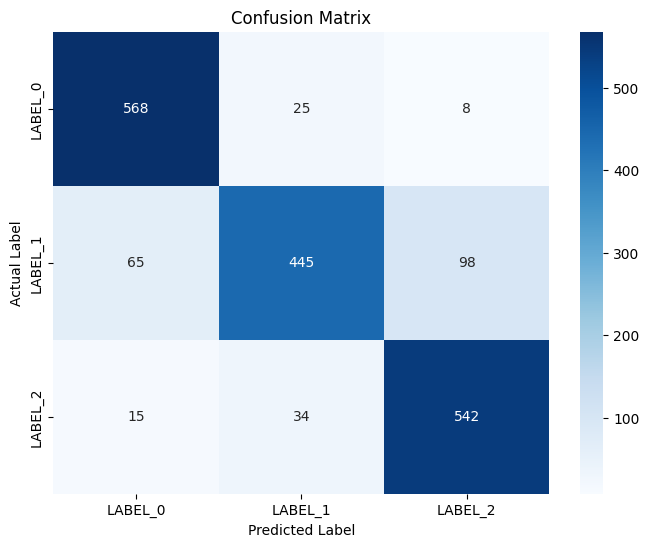

In [29]:
plot_cm(new_test_evals["confusion_matrix"])